In [1]:
import pandas as pd
import re
import numpy as np
import nltk
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt', quiet=True)
np.random.seed(0)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\byrdw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\byrdw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('tweets.csv')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
# Adjust display settings
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
df['emotion_in_tweet_is_directed_at'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [5]:
# Define the list of words you want to check for in the 'tweet_text' column
words_to_check = ['Apple', 'Google', 'ipad', 'Android', 'Android App']  # Change this to the words you want to check for

# Replace NaN values in 'tweet_text' column with an empty string
df['tweet_text'] = df['tweet_text'].fillna('')

# Filter the DataFrame to include only rows where 'emotion_in_tweet_is_directed_at' is NaN
filtered_df = df[df['emotion_in_tweet_is_directed_at'].isna()]

# Loop over each word to check for in the 'tweet_text' column
for word in words_to_check:
    # Use boolean indexing to find rows where 'tweet_text' contains the word
    rows_with_word = filtered_df[filtered_df['tweet_text'].str.contains(word, case=False)]
    
    # Update the value of 'emotion_in_tweet_is_directed_at' for the matching rows
    df.loc[rows_with_word.index, 'emotion_in_tweet_is_directed_at'] = word

# Print the updated DataFrame
print(df[['tweet_text', 'emotion_in_tweet_is_directed_at']])

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
8716                      Ipad everywhere. #SXSW {link}   
8717  Wave, buzz... RT @mention We interrupt your re...   
8718  Google's Zeiger, a physician never reported po...   
8719  Some Verizon iPhone customers complained their...   
8720  �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...   

     emotion_in_tweet_is_directed_at  
0                             iPhone  
1                 iPad or iPhone App  
2                               iPad  
3                 iPad or iPhone App  
4                             Google  
...                              ...  
8716              

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8721 non-null   object
 1   emotion_in_tweet_is_directed_at                     7311 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [7]:
tweet = 'Foursquare ups the game, #ipad  just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.'

In [8]:
tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

In [9]:
tweet

'Foursquare ups the game, #ipad  just in time for #SXSW  - Still prefer @Gowalla by far, best looking Android app to date.'

In [10]:
#def clean_tweet(tweet):
#    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # removing any url's
#    tweet = re.sub(r'\@\w+|\#', '', tweet) # removing hastags and usernames
#    tweet = tweet.lower() # making everything lowercase
#    tweet = re.sub(r'\W', ' ', tweet)
#    tweet = re.sub(r'\s+', ' ', tweet)
    
#    return tweet
#print(clean_tweet(tweet))

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
#    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = tweet.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
#    stemmed_cleaned_words = [stemmer.stem(word) for word in cleaned_words if word not in stop_words]
    return ' '.join(cleaned_words)

In [11]:
tweet

'Foursquare ups the game, #ipad  just in time for #SXSW  - Still prefer @Gowalla by far, best looking Android app to date.'

In [12]:
clean_tweet(tweet)

'foursquare ups game ipad time sxsw still prefer far best looking android app date'

In [13]:
df['tweet_text'] = df['tweet_text'].astype(str)

In [14]:
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

Tweets are cleaned and we can move on to the next step.  Now let's train the model.  
Encoding values to make a new column, sentiment.  
0=Undefined
1=Negative
2=Indifferent
3=Positve


In [15]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [16]:
df['sentiment']
df[df['sentiment']==0]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment
88,Thanks to @mention for publishing the news of ...,NaN,I can't tell,thanks publishing news new medical apps sxswi ...,0
100,���@mention &quot;Apple has opened a pop-up st...,ipad,I can't tell,quot apple opened pop store austin nerd town s...,0
228,Just what America needs. RT @mention Google to...,Google,I can't tell,america need rt google launch major new social...,0
330,The queue at the Apple Store in Austin is FOUR...,Apple,I can't tell,queue apple store austin four block long crazy...,0
357,Hope it's better than wave RT @mention Buzz is...,Google,I can't tell,hope better wave rt buzz google previewing soc...,0
...,...,...,...,...,...
8650,It's funny watching a room full of people hold...,ipad,I can't tell,funny watching room full people hold ipad air ...,0
8662,"@mention yeah, we have @mention , Google has n...",Google,I can't tell,yeah google nothing u sxsw,0
8667,"@mention Yes, the Google presentation was not ...",Google,I can't tell,yes google presentation exactly expecting sxsw,0
8687,&quot;Do you know what Apple is really good at...,ipad,I can't tell,quot know apple really good making feel bad xm...,0


In [17]:
df['emotion_in_tweet_is_directed_at'].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
8716                  iPad
8717                Google
8718                Google
8719                   nan
8720                Google
Name: emotion_in_tweet_is_directed_at, Length: 8721, dtype: object

In [18]:
#df['emotion_in_tweet_is_directed_at'].isna().sum()

In [19]:
#df['emotion_in_tweet_is_directed_at'].value_counts()

In [20]:
#label_encoder = LabelEncoder()
#df['target'] = label_encoder.fit_transform(df['emotion_in_tweet_is_directed_at'])

In [21]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3
...,...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link,3
8717,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz rt interrupt regularly scheduled sxs...,2
8718,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never reported potenti...,2
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,verizon iphone customer complained time fell b...,2


In [22]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3


In [23]:
df['tokenized_tweets'] = df['cleaned_tweet'].apply(word_tokenize)
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,tokenized_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,"[3g, iphone, 3, hr, tweeting, rise_austin, dea..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3,"[know, awesome, ipad, iphone, app, likely, app..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,"[wait, ipad, 2, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1,"[hope, year, festival, crashy, year, iphone, a..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,"[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [24]:
#df = df.drop('tweet_text', axis=1)

In [25]:
def count_vectorize(tokenized_list):
    corpus = {}
    
    for tokenized in tokenized_list:
        for word in tokenized:
            if word in corpus:
                corpus[word] += 1
            else:
                corpus[word] = 1

    return corpus

# Vectorize the tokenized tweets
test_vectorized = count_vectorize(df['tokenized_tweets'])
test_vectorized

{'3g': 29,
 'iphone': 1526,
 '3': 177,
 'hr': 5,
 'tweeting': 28,
 'rise_austin': 2,
 'dead': 16,
 'need': 234,
 'upgrade': 13,
 'plugin': 4,
 'station': 12,
 'sxsw': 9239,
 'know': 197,
 'awesome': 130,
 'ipad': 2438,
 'app': 796,
 'likely': 12,
 'appreciate': 4,
 'design': 136,
 'also': 78,
 'giving': 68,
 'free': 378,
 't': 2,
 'wait': 74,
 '2': 1195,
 'sale': 44,
 'hope': 53,
 'year': 165,
 'festival': 30,
 'crashy': 2,
 'great': 212,
 'stuff': 34,
 'fri': 7,
 'marissa': 186,
 'mayer': 213,
 'google': 2552,
 'tim': 19,
 'reilly': 9,
 'tech': 120,
 'book': 38,
 'conference': 72,
 'amp': 805,
 'matt': 11,
 'mullenweg': 2,
 'wordpress': 8,
 'new': 1066,
 'apps': 212,
 'speechtherapy': 3,
 'communication': 22,
 'showcased': 20,
 'iear': 3,
 'edchat': 39,
 'asd': 3,
 'starting': 32,
 'ctia': 4,
 'around': 130,
 'corner': 14,
 'googleio': 2,
 'hop': 3,
 'skip': 3,
 'jump': 6,
 'good': 165,
 'time': 291,
 'android': 567,
 'fan': 34,
 'beautifully': 2,
 'smart': 61,
 'simple': 10,
 'idea':

In [26]:
freq_df = pd.DataFrame(list(test_vectorized.items()), columns=['Word', 'Frequency'])
freq_df

,Word,Frequency
0,3g,29
1,iphone,1526
2,3,177
3,hr,5
4,tweeting,28
...,...,...
8577,complained,1
8578,yorkers,1
8579,ϡ,1
8580,ʋ,1


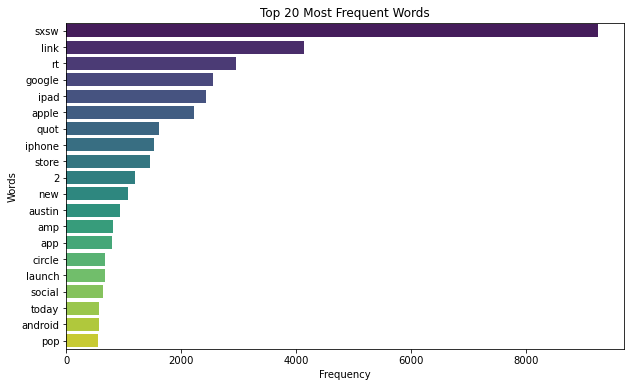

In [27]:
# Convert the word frequency dictionary to a DataFrame
freq_df = pd.DataFrame(list(test_vectorized.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=freq_df.head(20), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [28]:
freq_df

,Word,Frequency
11,sxsw,9239
210,link,4131
69,rt,2958
35,google,2552
14,ipad,2438
...,...,...
2945,sux,1
5894,carrie,1
5895,tuh,1
5896,nerdheaven,1


In [29]:
# Calculate the total number of tokens
total_word_count = freq_df['Frequency'].sum()

# Print the total number of tokens
print("Total word count:", total_word_count)

# Extract the top 50 most common words
df_top_50 = freq_df.head(50)

# Print the top 50 words and their normalized frequencies
print(f'{"Word":10} Normalized Frequency')
for word in df_top_50.iterrows():
    normalized_frequency = word[1]['Frequency'] / total_word_count
    print(f'{word[1]["Word"]:10} {normalized_frequency:.6f}')


Total word count: 103051
Word       Normalized Frequency
sxsw       0.089655
link       0.040087
rt         0.028704
google     0.024764
ipad       0.023658
apple      0.021514
quot       0.015730
iphone     0.014808
store      0.014139
2          0.011596
new        0.010344
austin     0.009083
amp        0.007812
app        0.007724
circle     0.006521
launch     0.006521
social     0.006249
today      0.005570
android    0.005502
pop        0.005395
network    0.004483
get        0.004289
line       0.004250
ipad2      0.004212
via        0.003950
party      0.003736
free       0.003668
called     0.003493
mobile     0.003328
sxswi      0.003261
one        0.002989
major      0.002931
like       0.002892
time       0.002824
day        0.002698
check      0.002533
map        0.002513
u          0.002504
temporary  0.002484
w          0.002475
win        0.002436
possibly   0.002368
opening    0.002358
need       0.002271
open       0.002251
go         0.002242
people     0.002203
com

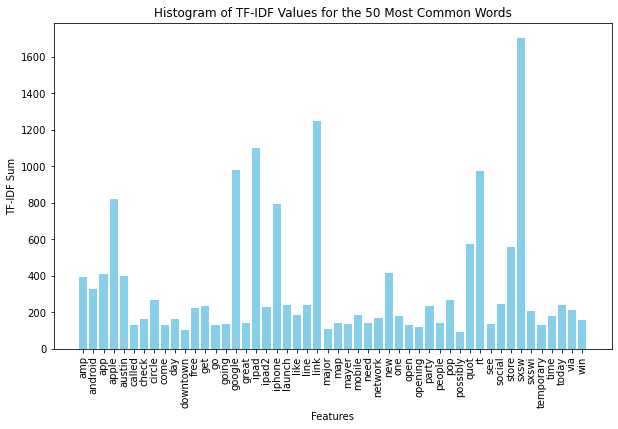

In [30]:
df['cleaned_tweet'] = df['cleaned_tweet'].astype(str)
df['cleaned_text'] = df['cleaned_tweet'].apply(clean_tweet)

text_data = df['cleaned_text'].tolist()

count_vectorizer = CountVectorizer(max_features=50)
X_counts = count_vectorizer.fit_transform(text_data)
common_words = count_vectorizer.get_feature_names()

vectorizer_tfid = TfidfVectorizer(vocabulary=common_words)
X_tfid = vectorizer_tfid.fit_transform(text_data)
tfidf_matrix = X_tfid.toarray()

feature_names = vectorizer_tfid.get_feature_names()

tfidf_sums = np.sum(tfidf_matrix, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(feature_names, tfidf_sums, color='skyblue')
plt.xlabel('Features')
plt.ylabel('TF-IDF Sum')
plt.title('Histogram of TF-IDF Values for the 50 Most Common Words')
plt.xticks(rotation=90)
plt.show()

In [31]:
def pos_tagging(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    return ' '.join([f"{word}_{tag}" for word, tag in pos_tags])

df['pos_tagged_text'] = df['cleaned_text'].apply(pos_tagging)

In [32]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,tokenized_tweets,cleaned_text,pos_tagged_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,"[3g, iphone, 3, hr, tweeting, rise_austin, dea...",3g iphone 3 hr tweeting rise_austin dead need ...,3g_CD iphone_NN 3_CD hr_NN tweeting_VBG rise_a...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know_VB awesome_JJ ipad_NN iphone_NN app_NN li...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,"[wait, ipad, 2, also, sale, sxsw]",wait ipad 2 also sale sxsw,wait_NN ipad_NN 2_CD also_RB sale_NN sxsw_NN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1,"[hope, year, festival, crashy, year, iphone, a...",hope year festival crashy year iphone app sxsw,hope_NN year_NN festival_NN crashy_JJ year_NN ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,"[great, stuff, fri, sxsw, marissa, mayer, goog...",great stuff fri sxsw marissa mayer google tim ...,great_JJ stuff_NN fri_NN sxsw_NN marissa_FW ma...
...,...,...,...,...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link,3,"[ipad, everywhere, sxsw, link]",ipad everywhere sxsw link,ipad_NN everywhere_RB sxsw_JJ link_NN
8717,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz rt interrupt regularly scheduled sxs...,2,"[wave, buzz, rt, interrupt, regularly, schedul...",wave buzz rt interrupt regularly scheduled sxs...,wave_NN buzz_NN rt_NN interrupt_VBP regularly_...
8718,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never reported potenti...,2,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...,google_NN zeiger_NN physician_NN never_RB repo...
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,verizon iphone customer complained time fell b...,2,"[verizon, iphone, customer, complained, time, ...",verizon iphone customer complained time fell b...,verizon_NN iphone_NN customer_NN complained_VB...


Tag	Description  
CC	Coordinating conjunction  
CD	Cardinal number  
DT	Determiner  
EX	Existential there  
FW	Foreign word  
IN	Preposition or subordinating conjunction  
JJ	Adjective  
JJR	Adjective, comparative  
JJS	Adjective, superlative  
LS	List item marker  
MD	Modal  
NN	Noun, singular or mass  
NNS	Noun, plural  
NNP	Proper noun, singular  
NNPS	Proper noun, plural  
PDT	Predeterminer  
POS	Possessive ending  
PRP	Personal pronoun  
PRP(dollar symbol)	Possessive pronoun  
RB	Adverb  
RBR	Adverb, comparative  
RBS	Adverb, superlative  
RP	Particle  
SYM	Symbol  
TO	To  
UH	Interjection  
VB	Verb, base form  
VBD	Verb, past tense  
VBG	Verb, gerund or present participle  
VBN	Verb, past participle  
VBP	Verb, non-3rd person singular present  
VBZ	Verb, 3rd person singular present  
WDT	Wh-determiner  
WP	Wh-pronoun  
WP$	Possessive wh-pronoun  
WRB	Wh-adverb  

Sentence: The quick brown fox jumps over the lazy dog.  
POS Tags: DT  JJ    JJ    NN  VBZ   IN   DT  JJ   NN  
           |   |     |    |    |     |    |   |    |  
           The quick brown fox jumps over the lazy dog

In [33]:
def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

# Apply the function to generate bigrams and trigrams
df['bigrams'] = df['cleaned_text'].apply(lambda x: generate_ngrams(x, 2))
df['trigrams'] = df['cleaned_text'].apply(lambda x: generate_ngrams(x, 3))

# Display the DataFrame with bigrams and trigrams
df['bigrams']

0       [3g iphone, iphone 3, 3 hr, hr tweeting, tweet...
1       [know awesome, awesome ipad, ipad iphone, ipho...
2       [wait ipad, ipad 2, 2 also, also sale, sale sxsw]
3       [hope year, year festival, festival crashy, cr...
4       [great stuff, stuff fri, fri sxsw, sxsw mariss...
                              ...                        
8716        [ipad everywhere, everywhere sxsw, sxsw link]
8717    [wave buzz, buzz rt, rt interrupt, interrupt r...
8718    [google zeiger, zeiger physician, physician ne...
8719    [verizon iphone, iphone customer, customer com...
8720    [ϡ _, _ ʋ, ʋ ҋ, ҋ _, _ _, _ rt, rt google, goo...
Name: bigrams, Length: 8721, dtype: object

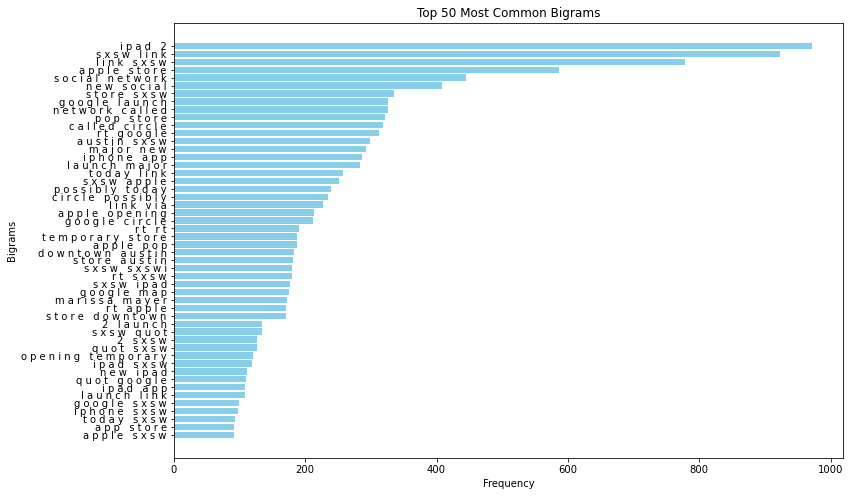

In [34]:
# Flatten the list of bigrams
all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Get the top 50 most common bigrams
top_50_bigrams = bigram_freq.most_common(50)

# Prepare data for the histogram
bigrams, counts = zip(*top_50_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.barh(bigram_labels, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 50 Most Common Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

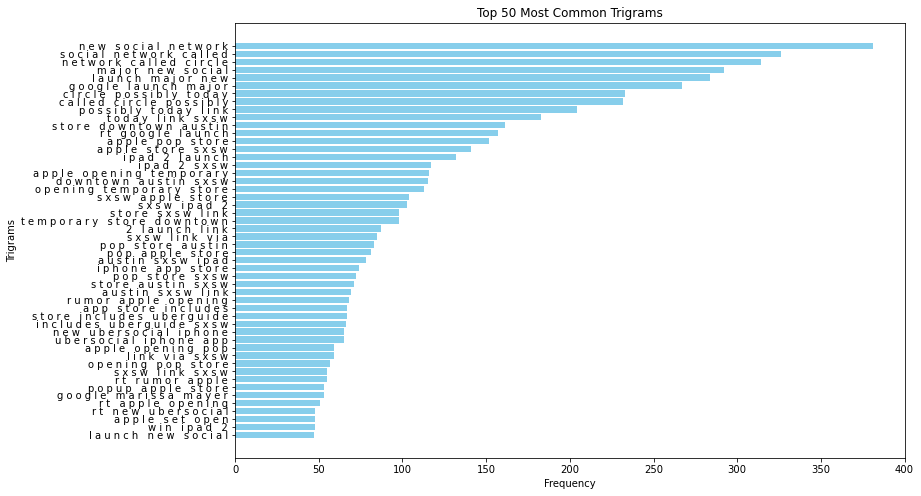

In [35]:
# Flatten the list of bigrams
all_trigrams = [trigram for sublist in df['trigrams'] for trigram in sublist]

# Count the frequency of each bigram
trigram_freq = Counter(all_trigrams)

# Get the top 50 most common bigrams
top_50_trigrams = trigram_freq.most_common(50)

# Prepare data for the histogram
trigrams, counts = zip(*top_50_trigrams)
trigram_labels = [' '.join(trigram) for trigram in trigrams]

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.barh(trigram_labels, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 50 Most Common Trigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

In [36]:
#vectorizer1 = CountVectorizer(ngram_range=(2, 3))

# Fit and transform the text data
#X_gram = vectorizer1.fit_transform(df['cleaned_text'])

# Convert the result to a DataFrame for easier viewing
#ngram_df = pd.DataFrame(X_gram.toarray(), columns=vectorizer1.get_feature_names())

# Display the DataFrame with bigrams and trigrams as features
#ngram_df

In [37]:
df['tweet_length'] = df['tweet_text'].apply(len)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,tokenized_tweets,cleaned_text,pos_tagged_text,bigrams,trigrams,tweet_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,"[3g, iphone, 3, hr, tweeting, rise_austin, dea...",3g iphone 3 hr tweeting rise_austin dead need ...,3g_CD iphone_NN 3_CD hr_NN tweeting_VBG rise_a...,"[3g iphone, iphone 3, 3 hr, hr tweeting, tweet...","[3g iphone 3, iphone 3 hr, 3 hr tweeting, hr t...",127
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know_VB awesome_JJ ipad_NN iphone_NN app_NN li...,"[know awesome, awesome ipad, ipad iphone, ipho...","[know awesome ipad, awesome ipad iphone, ipad ...",139
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,"[wait, ipad, 2, also, sale, sxsw]",wait ipad 2 also sale sxsw,wait_NN ipad_NN 2_CD also_RB sale_NN sxsw_NN,"[wait ipad, ipad 2, 2 also, also sale, sale sxsw]","[wait ipad 2, ipad 2 also, 2 also sale, also s...",79
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1,"[hope, year, festival, crashy, year, iphone, a...",hope year festival crashy year iphone app sxsw,hope_NN year_NN festival_NN crashy_JJ year_NN ...,"[hope year, year festival, festival crashy, cr...","[hope year festival, year festival crashy, fes...",82
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,"[great, stuff, fri, sxsw, marissa, mayer, goog...",great stuff fri sxsw marissa mayer google tim ...,great_JJ stuff_NN fri_NN sxsw_NN marissa_FW ma...,"[great stuff, stuff fri, fri sxsw, sxsw mariss...","[great stuff fri, stuff fri sxsw, fri sxsw mar...",131
...,...,...,...,...,...,...,...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link,3,"[ipad, everywhere, sxsw, link]",ipad everywhere sxsw link,ipad_NN everywhere_RB sxsw_JJ link_NN,"[ipad everywhere, everywhere sxsw, sxsw link]","[ipad everywhere sxsw, everywhere sxsw link]",29
8717,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz rt interrupt regularly scheduled sxs...,2,"[wave, buzz, rt, interrupt, regularly, schedul...",wave buzz rt interrupt regularly scheduled sxs...,wave_NN buzz_NN rt_NN interrupt_VBP regularly_...,"[wave buzz, buzz rt, rt interrupt, interrupt r...","[wave buzz rt, buzz rt interrupt, rt interrupt...",125
8718,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never reported potenti...,2,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...,google_NN zeiger_NN physician_NN never_RB repo...,"[google zeiger, zeiger physician, physician ne...","[google zeiger physician, zeiger physician nev...",145
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,verizon iphone customer complained time fell b...,2,"[verizon, iphone, customer, complained, time, ...",verizon iphone customer complained time fell b...,verizon_NN iphone_NN customer_NN complained_VB...,"[verizon iphone, iphone customer, customer com...","[verizon iphone customer, iphone customer comp...",140


In [38]:
df['tweet_length'].describe()

count    8721.000000
mean      105.309139
std        27.064501
min         0.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       171.000000
Name: tweet_length, dtype: float64

In [40]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,tokenized_tweets,cleaned_text,pos_tagged_text,bigrams,trigrams,tweet_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,"[3g, iphone, 3, hr, tweeting, rise_austin, dea...",3g iphone 3 hr tweeting rise_austin dead need ...,3g_CD iphone_NN 3_CD hr_NN tweeting_VBG rise_a...,"[3g iphone, iphone 3, 3 hr, hr tweeting, tweet...","[3g iphone 3, iphone 3 hr, 3 hr tweeting, hr t...",127
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know_VB awesome_JJ ipad_NN iphone_NN app_NN li...,"[know awesome, awesome ipad, ipad iphone, ipho...","[know awesome ipad, awesome ipad iphone, ipad ...",139
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,"[wait, ipad, 2, also, sale, sxsw]",wait ipad 2 also sale sxsw,wait_NN ipad_NN 2_CD also_RB sale_NN sxsw_NN,"[wait ipad, ipad 2, 2 also, also sale, sale sxsw]","[wait ipad 2, ipad 2 also, 2 also sale, also s...",79
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1,"[hope, year, festival, crashy, year, iphone, a...",hope year festival crashy year iphone app sxsw,hope_NN year_NN festival_NN crashy_JJ year_NN ...,"[hope year, year festival, festival crashy, cr...","[hope year festival, year festival crashy, fes...",82
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,"[great, stuff, fri, sxsw, marissa, mayer, goog...",great stuff fri sxsw marissa mayer google tim ...,great_JJ stuff_NN fri_NN sxsw_NN marissa_FW ma...,"[great stuff, stuff fri, fri sxsw, sxsw mariss...","[great stuff fri, stuff fri sxsw, fri sxsw mar...",131


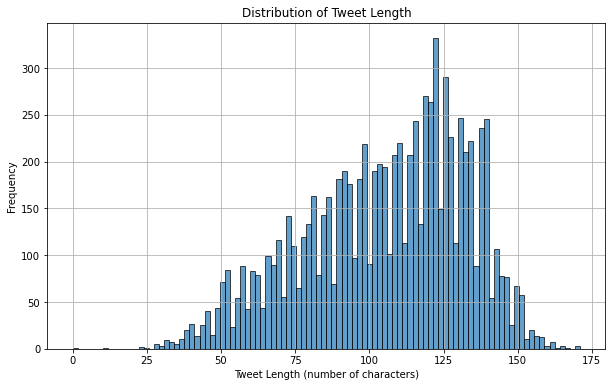

In [41]:
plt.figure(figsize=(10,6))
plt.hist(df['tweet_length'], bins = 100, edgecolor = 'black', alpha= 0.7)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length (number of characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [42]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,tokenized_tweets,cleaned_text,pos_tagged_text,bigrams,trigrams,tweet_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,"[3g, iphone, 3, hr, tweeting, rise_austin, dea...",3g iphone 3 hr tweeting rise_austin dead need ...,3g_CD iphone_NN 3_CD hr_NN tweeting_VBG rise_a...,"[3g iphone, iphone 3, 3 hr, hr tweeting, tweet...","[3g iphone 3, iphone 3 hr, 3 hr tweeting, hr t...",127
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,3,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know_VB awesome_JJ ipad_NN iphone_NN app_NN li...,"[know awesome, awesome ipad, ipad iphone, ipho...","[know awesome ipad, awesome ipad iphone, ipad ...",139
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,"[wait, ipad, 2, also, sale, sxsw]",wait ipad 2 also sale sxsw,wait_NN ipad_NN 2_CD also_RB sale_NN sxsw_NN,"[wait ipad, ipad 2, 2 also, also sale, sale sxsw]","[wait ipad 2, ipad 2 also, 2 also sale, also s...",79
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app sxsw,1,"[hope, year, festival, crashy, year, iphone, a...",hope year festival crashy year iphone app sxsw,hope_NN year_NN festival_NN crashy_JJ year_NN ...,"[hope year, year festival, festival crashy, cr...","[hope year festival, year festival crashy, fes...",82
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,"[great, stuff, fri, sxsw, marissa, mayer, goog...",great stuff fri sxsw marissa mayer google tim ...,great_JJ stuff_NN fri_NN sxsw_NN marissa_FW ma...,"[great stuff, stuff fri, fri sxsw, sxsw mariss...","[great stuff fri, stuff fri sxsw, fri sxsw mar...",131
...,...,...,...,...,...,...,...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link,3,"[ipad, everywhere, sxsw, link]",ipad everywhere sxsw link,ipad_NN everywhere_RB sxsw_JJ link_NN,"[ipad everywhere, everywhere sxsw, sxsw link]","[ipad everywhere sxsw, everywhere sxsw link]",29
8717,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz rt interrupt regularly scheduled sxs...,2,"[wave, buzz, rt, interrupt, regularly, schedul...",wave buzz rt interrupt regularly scheduled sxs...,wave_NN buzz_NN rt_NN interrupt_VBP regularly_...,"[wave buzz, buzz rt, rt interrupt, interrupt r...","[wave buzz rt, buzz rt interrupt, rt interrupt...",125
8718,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never reported potenti...,2,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...,google_NN zeiger_NN physician_NN never_RB repo...,"[google zeiger, zeiger physician, physician ne...","[google zeiger physician, zeiger physician nev...",145
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,verizon iphone customer complained time fell b...,2,"[verizon, iphone, customer, complained, time, ...",verizon iphone customer complained time fell b...,verizon_NN iphone_NN customer_NN complained_VB...,"[verizon iphone, iphone customer, customer com...","[verizon iphone customer, iphone customer comp...",140


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8721 non-null   object
 1   emotion_in_tweet_is_directed_at                     7311 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
 3   cleaned_tweet                                       8721 non-null   object
 4   sentiment                                           8721 non-null   int32 
 5   tokenized_tweets                                    8721 non-null   object
 6   cleaned_text                                        8721 non-null   object
 7   pos_tagged_text                                     8721 non-null   object
 8   bigrams                                             8721 non-null   object
 9   trigrams

In [44]:
df.shape

(8721, 11)

In [45]:
#ngrams_df

In [46]:
df['tokenized_tweets'] = df['tokenized_tweets'].astype(str)

In [47]:
print(type(df['cleaned_tweet']))

<class 'pandas.core.series.Series'>


In [48]:
unique_values = df['sentiment'].unique()
print(unique_values)

[1 3 2 0]


In [49]:
df['pos_tagged_text'] = df['pos_tagged_text'].astype(str)
df['bigrams'] = df['bigrams'].astype(str)
df['trigrams'] = df['trigrams'].astype(str)

In [50]:
X = df[['pos_tagged_text', 'bigrams', 'trigrams']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Define column transformer for TF-IDF vectorization
preprocessor = ColumnTransformer(
    transformers=[
        ('pos_tagged_text', TfidfVectorizer(max_features=5000), 'pos_tagged_text'),
        ('bigrams', TfidfVectorizer(max_features=5000), 'bigrams'),
        ('trigrams', TfidfVectorizer(max_features=5000), 'trigrams')
    ]
)

In [52]:
# Create a pipeline that includes preprocessing and the logistic regression classifier
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the pipeline
logistic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_pipeline.predict(X_test)

# Evaluate the pipeline
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Logistic Regression Accuracy: {accuracy_logistic:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.49      0.19      0.27        94
           2       0.72      0.81      0.76      1076
           3       0.55      0.51      0.53       535

    accuracy                           0.67      1745
   macro avg       0.44      0.38      0.39      1745
weighted avg       0.64      0.67      0.65      1745



In [53]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['liblinear', 'saga']  # Solvers
}

# Set up GridSearchCV with the logistic regression pipeline
grid_search = GridSearchCV(estimator=logistic_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score:.2f}')

# Make predictions with the best estimator
best_logistic_model = grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)

# Evaluate the best model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Logistic Regression Accuracy: {accuracy_logistic:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Best parameters found: {'classifier__C': 1, 'classifier__solver': 'liblinear'}
Best cross-validation accuracy: 0.67
Logistic Regression Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.52      0.13      0.21        94
           2       0.72      0.84      0.77      1076
           3       0.55      0.48      0.52       535

    accuracy                           0.67      1745
   macro avg       0.45      0.36      0.37      1745
weighted avg       0.64      0.67      0.65      1745



C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# Create a pipeline that includes preprocessing and the decision tree classifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Train the pipeline
decision_tree_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_tree = decision_tree_pipeline.predict(X_test)

# Evaluate the pipeline
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {accuracy_tree:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.58
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.25      0.26      0.25        94
           2       0.70      0.70      0.70      1076
           3       0.44      0.45      0.44       535

    accuracy                           0.58      1745
   macro avg       0.34      0.35      0.35      1745
weighted avg       0.58      0.58      0.58      1745



In [55]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with the decision tree pipeline
grid_search = GridSearchCV(estimator=decision_tree_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score:.2f}')

# Make predictions with the best estimator
best_tree_model = grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)

# Evaluate the best model
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {accuracy_tree:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best cross-validation accuracy: 0.62
Decision Tree Accuracy: 0.63
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.38      0.05      0.09        94
           2       0.66      0.88      0.75      1076
           3       0.52      0.29      0.37       535

    accuracy                           0.63      1745
   macro avg       0.39      0.30      0.30      1745
weighted avg       0.59      0.63      0.58      1745



C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# Create a pipeline that includes preprocessing and the KNN classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Train the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate the pipeline
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.63
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.39      0.15      0.22        94
           2       0.65      0.92      0.76      1076
           3       0.53      0.17      0.26       535

    accuracy                           0.63      1745
   macro avg       0.39      0.31      0.31      1745
weighted avg       0.58      0.63      0.56      1745



In [57]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2]
}

# Set up GridSearchCV with the KNN pipeline
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search_knn.fit(X_train, y_train)

# Get the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print(f'Best parameters found for KNN: {best_params_knn}')
print(f'Best cross-validation accuracy for KNN: {best_score_knn:.2f}')

# Make predictions with the best estimator
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

# Evaluate the best model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KeyboardInterrupt: 

In [ ]:
# Create a pipeline that includes preprocessing and the Gradient Boosting classifier
gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Train the pipeline
gradient_boosting_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_gradient_boosting = gradient_boosting_pipeline.predict(X_test)

# Evaluate the pipeline
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
print(f'Gradient Boosting Accuracy: {accuracy_gradient_boosting:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gradient_boosting))

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 1.0]
}

# Set up GridSearchCV with the Gradient Boosting pipeline
grid_search_gb = GridSearchCV(estimator=gradient_boosting_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print(f'Best parameters found for Gradient Boosting: {best_params_gb}')
print(f'Best cross-validation accuracy for Gradient Boosting: {best_score_gb:.2f}')

# Make predictions with the best estimator
best_gb_model = grid_search_gb.best_estimator_
y_pred_gradient_boosting = best_gb_model.predict(X_test)

# Evaluate the best model
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
print(f'Gradient Boosting Accuracy: {accuracy_gradient_boosting:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gradient_boosting))

In [ ]:
# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Create a pipeline that includes preprocessing and the stacking classifier
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000)
    ))
])

# Train the pipeline
stacking_clf.fit(X_train, y_train)

#make predictions
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the pipeline
stack_accuracy = stacking_clf.score(X_test, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy:.2f}')
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))

# Similarly, for voting classifier
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('decision_tree', DecisionTreeClassifier()),
            ('knn', KNeighborsClassifier()),
            ('logistic', LogisticRegression(max_iter=1000)),
            ('gradient_boosting', GradientBoostingClassifier())
        ],
        voting='soft'  # Change to 'hard' for majority voting
    ))
])

# Train the pipeline
voting_clf.fit(X_train, y_train)

# Make Predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the pipeline
vote_accuracy = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy:.2f}')
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))

In [ ]:
# Converting _train and X_test to dataframes for modeling
X_train = pd.DataFrame(X_train, columns=['pos_tagged_text', 'bigrams', 'trigrams'])
X_test = pd.DataFrame(X_test, columns=['pos_tagged_text', 'bigrams', 'trigrams'])

# Define the best models from grid search
best_tree_model = DecisionTreeClassifier()  
best_knn_model = KNeighborsClassifier()  
best_logistic_model = LogisticRegression(max_iter=1000)  
best_gb_model = GradientBoostingClassifier() 

# Create the stacking classifier pipeline
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=[
            ('decision_tree', best_tree_model),
            ('knn', best_knn_model),
            ('logistic', best_logistic_model),
            ('gradient_boosting', best_gb_model)
        ],
        final_estimator=LogisticRegression(max_iter=1000)
    ))
])

# Train the stacking pipeline
stacking_clf.fit(X_train, y_train)

# Make predictions and evaluate the stacking pipeline
y_pred_stacking = stacking_clf.predict(X_test)
stack_accuracy = stacking_clf.score(X_test, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy:.2f}')
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))

# Create the voting classifier pipeline
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('decision_tree', best_tree_model),
            ('knn', best_knn_model),
            ('logistic', best_logistic_model),
            ('gradient_boosting', best_gb_model)
        ],
        voting='soft'  # Change to 'hard' for majority voting
    ))
])

# Train the voting pipeline
voting_clf.fit(X_train, y_train)

# Make predictions and evaluate the voting pipeline
y_pred_voting = voting_clf.predict(X_test)
vote_accuracy = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy:.2f}')
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))


In [ ]:
X_ct = df['cleaned_tweet']
y = df['sentiment']
X_train_ct, X_test_ct, y_train, y_test = train_test_split(X_ct, y, test_size=0.2, random_state=42)

In [ ]:
X_tt = df['tokenized_tweets']
y = df['sentiment']
X_train_tt, X_test_tt, y_train, y_test = train_test_split(X_tt, y, test_size=0.2, random_state=42)

In [ ]:
df['bigrams'] = df['bigrams'].astype(str)

In [ ]:
df['trigrams'] = df['trigrams'].astype(str)

In [ ]:
X_bi = df['bigrams']
y = df['sentiment']
X_train_bi, X_test_bi, _, _ = train_test_split(X_bi, y, test_size=0.2, random_state=42)

In [ ]:
X_tri = df['trigrams']
y = df['sentiment']
X_train_tri, X_test_tri, _, _ = train_test_split(X_bi, y, test_size=0.2, random_state=42)

In [ ]:
print(type(X))

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_tt = vectorizer.fit_transform(X_train_tt)
X_test_tfidf_tt = vectorizer.transform(X_test_tt)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_ct = vectorizer.fit_transform(X_train_ct)
X_test_tfidf_ct = vectorizer.transform(X_test_ct)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_ct = vectorizer.fit_transform(X_train_ct)
X_test_tfidf_ct = vectorizer.transform(X_test_ct)

In [ ]:
vectorizer_bi = TfidfVectorizer(max_features=5000)
X_train_tfidf_bi = vectorizer_bi.fit_transform(X_train_bi)
X_test_tfidf_bi = vectorizer_bi.transform(X_test_bi)

In [ ]:
vectorizer_tri = TfidfVectorizer(max_features=5000)
X_train_tfidf_tri = vectorizer_tri.fit_transform(X_train_tri)
X_test_tfidf_tri = vectorizer_tri.transform(X_test_tri)

In [ ]:
X_train_tfidf

In [ ]:
X_train_tfidf.shape

In [ ]:
X_train.shape

In [ ]:
vectorizer

In [ ]:
X_train_tfidf.shape

In [ ]:
X_test_tfidf.shape

In [ ]:
#X = df.drop(columns=['sentiment'])
#y = df['sentiment']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's build a multiclass classification Logistic Regression

In [ ]:
model = LogisticRegression(multi_class='ovr')
model.fit(X_train_tfidf, y_train)

In [ ]:
model_ct = LogisticRegression(multi_class='ovr')
model_ct.fit(X_train_tfidf_ct, y_train)

In [ ]:
model_tt = LogisticRegression(multi_class='ovr')
model_tt.fit(X_train_tfidf_tt, y_train)

In [ ]:
model_bi = LogisticRegression(multi_class='ovr')
model_bi.fit(X_train_tfidf_bi, y_train)

In [ ]:
model_tri = LogisticRegression(multi_class='ovr')
model_tri.fit(X_train_tfidf_tri, y_train)

In [ ]:
y_pred = model.predict(X_test_tfidf)
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
# Convert class labels to strings
class_labels = [str(label) for label in label_encoder.classes_]

#below works for tokenized_tweets
# Print classification report
print(classification_report(y_test, y_pred, target_names=class_labels))

#below worked for cleaned_tweet
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
y_pred_ct = model_ct.predict(X_test_tfidf_ct)
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred_ct))
# Convert class labels to strings
class_labels = [str(label) for label in label_encoder.classes_]

#below works for tokenized_tweets
# Print classification report
print(classification_report(y_test, y_pred_ct, target_names=class_labels))

#below worked for cleaned_tweet
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
y_pred_tt = model_ct.predict(X_test_tfidf_tt)
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred_tt))
# Convert class labels to strings
class_labels = [str(label) for label in label_encoder.classes_]

#below works for tokenized_tweets
# Print classification report
print(classification_report(y_test, y_pred_tt, target_names=class_labels))

#below worked for cleaned_tweet
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
y_pred_bi = model_bi.predict(X_test_tfidf_bi)
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred_bi))
# Convert class labels to strings
class_labels = [str(label) for label in label_encoder.classes_]

#below works for tokenized_tweets
# Print classification report
print(classification_report(y_test, y_pred_bi, target_names=class_labels))

#below worked for cleaned_tweet
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
y_pred_tri = model_tri.predict(X_test_tfidf_tri)
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred_tri))
# Convert class labels to strings
class_labels = [str(label) for label in label_encoder.classes_]

#below works for tokenized_tweets
# Print classification report
print(classification_report(y_test, y_pred_tri, target_names=class_labels))

#below worked for cleaned_tweet
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

**KNN


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test_tfidf)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Generate classification report
classification_rep_knn = classification_report(y_test, y_pred_knn)

# Print the evaluation metrics
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_rep_knn)

In [ ]:
knn_ct = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn_ct.fit(X_train_tfidf_ct, y_train)

# Make predictions
y_pred_knn_ct = knn_ct.predict(X_test_tfidf_ct)

# Calculate accuracy
accuracy_knn_ct = accuracy_score(y_test, y_pred_knn_ct)

# Generate classification report
classification_rep_knn_ct = classification_report(y_test, y_pred_knn_ct)

# Print the evaluation metrics
print("Accuracy:", accuracy_knn_ct)
print("Classification Report:")
print(classification_rep_knn_ct)

In [ ]:
knn_tt = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn_tt.fit(X_train_tfidf_tt, y_train)

# Make predictions
y_pred_knn_tt = knn_tt.predict(X_test_tfidf_tt)

# Calculate accuracy
accuracy_knn_tt = accuracy_score(y_test, y_pred_knn_tt)

# Generate classification report
classification_rep_knn_tt = classification_report(y_test, y_pred_knn_tt)

# Print the evaluation metrics
print("Accuracy:", accuracy_knn_tt)
print("Classification Report:")
print(classification_rep_knn_tt)

In [ ]:
knn_bi = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn_bi.fit(X_train_tfidf_bi, y_train)

# Make predictions
y_pred_knn_bi = knn_tt.predict(X_test_tfidf_bi)

# Calculate accuracy
accuracy_knn_bi = accuracy_score(y_test, y_pred_knn_bi)

# Generate classification report
classification_rep_knn_bi = classification_report(y_test, y_pred_knn_bi)

# Print the evaluation metrics
print("Accuracy:", accuracy_knn_bi)
print("Classification Report:")
print(classification_rep_knn_bi)

In [ ]:
knn_tri = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn_tri.fit(X_train_tfidf_tri, y_train)

# Make predictions
y_pred_knn_tri = knn_tt.predict(X_test_tfidf_tri)

# Calculate accuracy
accuracy_knn_tri = accuracy_score(y_test, y_pred_knn_tri)

# Generate classification report
classification_rep_knn_tri = classification_report(y_test, y_pred_knn_tri)

# Print the evaluation metrics
print("Accuracy:", accuracy_knn_tri)
print("Classification Report:")
print(classification_rep_knn_tri)

In [ ]:
## Generate a synthetic dataset
#X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN model
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train_tfidf, y_train)

# Create a mesh grid for plotting decision boundaries
#h = .02  # step size in the mesh
#x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict classifications for each point in the mesh grid
#Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

# Plot the decision boundaries
#plt.figure(figsize=(10, 6))
#plt.contourf(xx, yy, Z, alpha=0.4, cmap=sns.color_palette("coolwarm", as_cmap=True))

# Plot the training and testing points
#sns.scatterplot(x=X_train_tfidf[:, 0], y=X_train_tfidf[:, 1], hue=y_train_tfidf, palette='coolwarm', marker='o', s=100, label='Train')
#sns.scatterplot(x=X_test_tfidf[:, 0], y=X_test_tfidf[:, 1], hue=y_test, palette='coolwarm', marker='X', s=100, label='Test')

#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.title('KNN Decision Boundaries')
#plt.legend()
#plt.show()


Decision Tree



In [ ]:
# Step 1: Initialize and train the decision tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_tfidf, y_train)

# Step 2: Make predictions
y_pred_dt = decision_tree.predict(X_test_tfidf)

# Step 3: Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print("Accuracy:", accuracy_dt)
print("Classification Report:")
print(classification_rep_dt)


In [ ]:
# Step 1: Initialize and train the decision tree model
decision_tree_ct = DecisionTreeClassifier()
decision_tree_ct.fit(X_train_tfidf_ct, y_train)

# Step 2: Make predictions
y_pred_dt_ct = decision_tree.predict(X_test_tfidf_ct)

# Step 3: Evaluate the model
accuracy_dt_ct = accuracy_score(y_test, y_pred_dt_ct)
classification_rep_dt_ct = classification_report(y_test, y_pred_dt_ct)

print("Accuracy:", accuracy_dt_ct)
print("Classification Report:")
print(classification_rep_dt_ct)


In [ ]:
# Step 1: Initialize and train the decision tree model
decision_tree_tt = DecisionTreeClassifier()
decision_tree_tt.fit(X_train_tfidf_tt, y_train)

# Step 2: Make predictions
y_pred_dt_tt = decision_tree.predict(X_test_tfidf_tt)

# Step 3: Evaluate the model
accuracy_dt_tt = accuracy_score(y_test, y_pred_dt_tt)
classification_rep_dt_tt = classification_report(y_test, y_pred_dt_tt)

print("Accuracy:", accuracy_dt_tt)
print("Classification Report:")
print(classification_rep_dt_tt)


In [ ]:
# Step 1: Initialize and train the decision tree model
decision_tree_bi = DecisionTreeClassifier()
decision_tree_bi.fit(X_train_tfidf_bi, y_train)

# Step 2: Make predictions
y_pred_dt_bi = decision_tree.predict(X_test_tfidf_bi)

# Step 3: Evaluate the model
accuracy_dt_bi = accuracy_score(y_test, y_pred_dt_bi)
classification_rep_dt_bi = classification_report(y_test, y_pred_dt_bi)

print("Accuracy:", accuracy_dt_bi)
print("Classification Report:")
print(classification_rep_dt_bi)


In [ ]:
# Step 1: Initialize and train the decision tree model
decision_tree_tri = DecisionTreeClassifier()
decision_tree_tri.fit(X_train_tfidf_tri, y_train)

# Step 2: Make predictions
y_pred_dt_tri = decision_tree.predict(X_test_tfidf_tri)

# Step 3: Evaluate the model
accuracy_dt_tri = accuracy_score(y_test, y_pred_dt_tri)
classification_rep_dt_tri = classification_report(y_test, y_pred_dt_tri)

print("Accuracy:", accuracy_dt_tri)
print("Classification Report:")
print(classification_rep_dt_tri)


Let's check if there is a class imbalance problem.

In [ ]:
df['sentiment'].value_counts()

In [ ]:
#vectorizer_count = CountVectorizer()
#train_data_X = vectorizer.fit_transform(df)
#vocab = vectorizer.get_feature_names()
#print(train_data_X.toarray())

In [ ]:
#print(vocab)

In [ ]:
#model = LogisticRegression(multi_class='ovr', class_weight='balanced')
#model.fit(X_train_tfidf, y_train)
#y_pred = model.predict(X_test_tfidf)
#target_names = label_encoder.classes_.tolist()

#print("Multiclass CLassifier Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import classification_report

# Convert label_encoder.classes_ to a list of strings
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Print classification report
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
#model = LogisticRegression(multi_class='ovr', class_weight='balanced')
#model.fit(X_train_resampled, y_train_resampled)
#y_pred = model.predict(X_test_tfidf)
#print("Multiclass CLassifier Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
# Convert label_encoder.classes_ to a list of strings
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Print classification report
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

# Train stacking classifier
stacking_clf.fit(X_train_tfidf, y_train)

# Evaluate
stack_accuracy_ensemble = stacking_clf.score(X_test_tfidf, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy_ensemble:.2f}')


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris


# Define base models
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
logistic = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier()

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('logistic', logistic),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_tfidf, y_train)

# Evaluate
vote_accuracy_ensemble_tfidf = voting_clf.score(X_test_tfidf, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy_ensemble_tfidf:.2f}')


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

# Train stacking classifier
stacking_clf.fit(X_train_tfidf_tt, y_train)

# Evaluate
stack_accuracy_ensemble_tt = stacking_clf.score(X_test_tfidf_tt, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy_ensemble_tt:.2f}')

In [ ]:
# Define base models
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
logistic = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier()

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('logistic', logistic),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_tfidf_tt, y_train)

# Evaluate
vote_accuracy_tfidf_tt = voting_clf.score(X_test_tfidf_tt, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy_tfidf_tt:.2f}')


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000))
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
)

# Train stacking classifier
stacking_clf.fit(X_train_tfidf_ct, y_train)

# Evaluate
accuracy_ensemble_ct = stacking_clf.score(X_test_tfidf_ct, y_test)
print(f'Stacking Classifier Accuracy: {accuracy_ensemble_ct:.2f}')

In [ ]:
# Define base models
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
logistic = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier()

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('logistic', logistic),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_tfidf_ct, y_train)

# Evaluate
vote_accuracy_tfidf_ct = voting_clf.score(X_test_tfidf_ct, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy_tfidf_ct:.2f}')

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

# Train stacking classifier
stacking_clf.fit(X_train_tfidf_bi, y_train)

# Evaluate
stack_accuracy_ensemble_bi = stacking_clf.score(X_test_tfidf_bi, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy_ensemble_bi:.2f}')

In [ ]:
# Define base models
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
logistic = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier()

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('logistic', logistic),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_tfidf_bi, y_train)

# Evaluate
vote_accuracy_tfidf_bi = voting_clf.score(X_test_tfidf_bi, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy_tfidf_bi:.2f}')

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

# Train stacking classifier
stacking_clf.fit(X_train_tfidf_tri, y_train)

# Evaluate
accuracy_ensemble_tri = stacking_clf.score(X_test_tfidf_tri, y_test)
print(f'Stacking Classifier Accuracy: {accuracy_ensemble_tri:.2f}')

In [ ]:
# Define base models
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
logistic = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier()

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('knn', knn),
        ('logistic', logistic),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_tfidf_tri, y_train)

# Evaluate
vote_accuracy_tfidf_tri = voting_clf.score(X_test_tfidf_tri, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy_tfidf_tri:.2f}')

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  # Solvers
    'multi_class': ['ovr', 'multinomial']  # Multi-class strategy
}

# Initialize the model
model = LogisticRegression(multi_class='ovr', class_weight='balanced')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_tfidf)

target_names = [str(class_name) for class_name in label_encoder.classes_.astype('str')]

# Print classification report
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
# Print best parameters
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

We can see oversampling the minority class negatively impacts the majority class and overall accuracy of our model.

In [ ]:
undersample = RandomUnderSampler()
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train_tfidf, y_train)


Undersampling severly impacted our model from an accuracy perspective, but did improve recall on our minority class.

In [ ]:
model = LogisticRegression(multi_class='ovr', class_weight='balanced')
model.fit(X_train_undersample, y_train_undersample)
y_pred = model.predict(X_test_tfidf)
target_names = [str(class_name) for class_name in label_encoder.classes_.astype('str')]

# Print classification report
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  # Solvers
    'multi_class': ['ovr', 'multinomial']  # Multi-class strategy
}

# Initialize the model
logreg = LogisticRegression(class_weight='balanced')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_tfidf)

target_names = [str(class_name) for class_name in label_encoder.classes_.astype('str')]

# Print classification report
print("Multiclass Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
# Print best parameters
print("Best parameters found by GridSearchCV:", grid_search.best_params_)